In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from pathlib import Path
import NanowireNetworkEvolutionFunctions as nnef
df = pd.read_csv('Results/evolution_under_node_removal/MCTS_bc_node_removal_002/evolveData.csv')
df

,trial,centrality,percMultiple,resistance,nwLength,nwDiam,width,height,lengthUnits,C_ext_per_length,C_ext_per_wire,n_s,transparency,fom
0,1,MCTS,2.359316,12.851853,10,0.15,25,25,um,2.707828e-07,2.707828e-12,1.632000e+11,0.642803,59.315825
1,1,MCTS,1.873574,13.154460,10,0.15,25,25,um,2.707828e-07,2.707828e-12,1.296000e+11,0.704030,74.710724
2,1,MCTS,1.850444,13.554074,10,0.15,25,25,um,2.707828e-07,2.707828e-12,1.280000e+11,0.707087,73.496254
3,1,MCTS,1.827313,13.648198,10,0.15,25,25,um,2.707828e-07,2.707828e-12,1.264000e+11,0.710157,73.995711
4,1,MCTS,1.804183,14.531069,10,0.15,25,25,um,2.707828e-07,2.707828e-12,1.248000e+11,0.713240,70.469386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,50,betweenness_centrality,1.225919,106.862259,10,0.15,25,25,um,2.707828e-07,2.707828e-12,8.480000e+10,0.794833,14.498745
2445,50,betweenness_centrality,1.110266,106.967632,10,0.15,25,25,um,2.707828e-07,2.707828e-12,7.680000e+10,0.812239,16.081697
2446,50,betweenness_centrality,0.971483,108.811731,10,0.15,25,25,um,2.707828e-07,2.707828e-12,6.720000e+10,0.833630,18.187320
2447,50,betweenness_centrality,0.809569,108.814750,10,0.15,25,25,um,2.707828e-07,2.707828e-12,5.600000e+10,0.859299,21.992594


In [2]:
# ensuring that everything is sorted in the correct order
df = df.sort_values(
    by = ['trial', 'centrality', 'percMultiple'],
    ascending = [True, True, True]
)
interps = df.groupby(['trial', 'centrality']).apply(
    lambda row : scipy.interpolate.interp1d(
        x = row['percMultiple'],
        y = row['fom'],
        assume_sorted = True,
        bounds_error = False
    )
)

def nansem(x):
    return np.nan if (x==x).sum() <= 1 else scipy.stats.sem(x, nan_policy = 'omit')

sdfs = []

interps = interps.reset_index().rename(columns = {0 : 'func'})
for percMultiple in np.linspace(df.percMultiple.max(), df.percMultiple.min(), 100):
    interps['fom'] = interps['func'].apply(
        lambda x : x(percMultiple)
    )
    sdf = interps.groupby('centrality')['fom'].aggregate(
        [np.nanmean, nansem]
    )
    sdf['percMultiple'] = percMultiple
    sdfs.append(sdf.reset_index())
sdf = pd.concat(sdfs)
sdf = sdf.dropna()
sdf = sdf.rename(columns = {
    'nanmean' : 'fom mean',
    'nansem' : 'fom sem'}
                )

In [3]:
sdf

,centrality,fom mean,fom sem,percMultiple
0,MCTS,73.202608,16.142816,2.948560
1,betweenness_centrality,73.269812,16.138357,2.948560
2,random_cleaned,73.098264,16.049962,2.948560
0,MCTS,74.079200,16.292234,2.919355
1,betweenness_centrality,74.243294,16.335953,2.919355
...,...,...,...,...
1,betweenness_centrality,96.619153,14.170432,0.232474
0,MCTS,162.699423,9.253344,0.203268
0,MCTS,171.272641,11.236668,0.174063
0,MCTS,202.201391,10.534819,0.144858


In [4]:
# making percolation theory data
trans_data = df[['percMultiple', 'transparency']].drop_duplicates().sort_values('percMultiple').reset_index(drop = True)
trans_interp = scipy.interpolate.interp1d(
    x = trans_data.percMultiple,
    y = trans_data.transparency,
    assume_sorted = True
)

# adding transparency data into sdf
sdf['transparency'] = sdf['percMultiple'].apply(
    trans_interp
)
sdf['resistance'] = sdf.apply(
    lambda x : 188.5 / (x['fom mean'] * (x.transparency**(-1/2) - 1)),
    axis = 1
)
sdf

,centrality,fom mean,fom sem,percMultiple,transparency,resistance
0,MCTS,73.202608,16.142816,2.948560,0.575636,8.096796
1,betweenness_centrality,73.269812,16.138357,2.948560,0.575636,8.089369
2,random_cleaned,73.098264,16.049962,2.948560,0.575636,8.108353
0,MCTS,74.079200,16.292234,2.919355,0.578791,8.092530
1,betweenness_centrality,74.243294,16.335953,2.919355,0.578791,8.074644
...,...,...,...,...,...,...
1,betweenness_centrality,96.619153,14.170432,0.232474,0.957391,88.637464
0,MCTS,162.699423,9.253344,0.203268,0.962643,60.284806
0,MCTS,171.272641,11.236668,0.174063,0.967925,66.969631
0,MCTS,202.201391,10.534819,0.144858,0.973234,68.255806


In [5]:
# now adding resistance data in (solving for ut using fom and transparency)

trans_data = trans_data[trans_data.percMultiple > 1]
# making evenly spaced data
ptdf = pd.DataFrame(columns = ['percMultiple', 'transparency', 'fom'])
ptdf['percMultiple'] = np.linspace(trans_data.percMultiple.min(), sdf.percMultiple.max(), 100) # we are taking that maximum percMultiple that has values in sdf so our starting values all match
ptdf['transparency'] = ptdf['percMultiple'].apply(
    trans_interp
)
# find initial resistance data
R0 = sdf['resistance'].iloc[
    np.argmax(sdf.percMultiple)
]
# R = C(n_s - n_c^eff)^-gamma
# new constant of proportionality
# R = C(n_s / n_c^eff - 1)^-gamma
# R = C(percMultiple - 1)^-gamma
# C = R (percMultiple - 1)^gamma
gamma = 1.29
C = R0 * (ptdf.percMultiple.max() - 1)**(gamma)
ptdf['resistance'] = ptdf['percMultiple'].apply(
    lambda pm : C * (pm - 1)**(-gamma)
)
ptdf['fom'] = ptdf.apply(
    lambda x : nnef.fom(transparency = x.transparency, resistance = x.resistance),
    axis = 1
)
ptdf['centrality'] = 'percolation_theory'
ptdf

,percMultiple,transparency,fom,resistance,centrality
0,1.017744,0.826437,0.542649,3473.497567,percolation_theory
1,1.037247,0.823425,1.384550,1334.544523,percolation_theory
2,1.056750,0.820423,2.337364,775.218368,percolation_theory
3,1.076254,0.817432,3.356428,529.575852,percolation_theory
4,1.095757,0.814451,4.418420,394.761915,percolation_theory
...,...,...,...,...,...
95,2.870548,0.584115,71.605919,8.535016,percolation_theory
96,2.890051,0.581976,72.009514,8.421574,percolation_theory
97,2.909554,0.579853,72.411215,8.310782,percolation_theory
98,2.929057,0.577743,72.809593,8.202550,percolation_theory


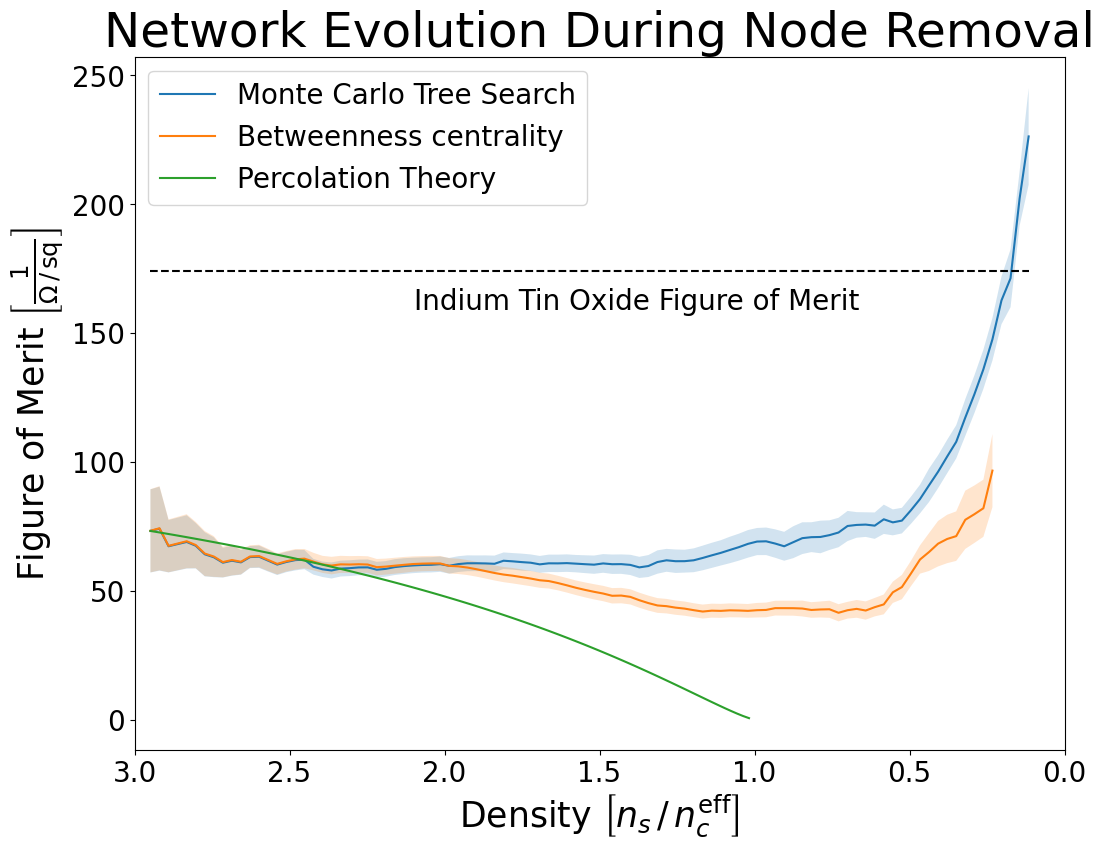

In [6]:
sdf = sdf.sort_values(by = ['centrality', 'percMultiple'], ascending = [True, False])

fig, ax = plt.subplots(
    figsize = (12,9)
)
for centrality in sdf.centrality.unique():
    if centrality == 'random_cleaned':
        continue
    cdf = sdf[sdf.centrality == centrality]
    ax.plot(
        cdf['percMultiple'], cdf['fom mean'],
        label = 'Monte Carlo Tree Search' if centrality == 'MCTS' else centrality.replace('_',' ').capitalize() 
    )
    ax.fill_between(
        cdf.percMultiple,
        cdf['fom mean'] - cdf['fom sem'],
        cdf['fom mean'] + cdf['fom sem'],
        alpha = 0.2
    )
    




# plotting percolation theory data
ax.plot(
    ptdf['percMultiple'],
    ptdf['fom'],
    label = 'Percolation Theory'
)

# marking ITO on plot
ito_fom = nnef.fom(transparency = 0.9, resistance = 20)
ito_line = plt.Line2D(
    (sdf.percMultiple.max(), sdf.percMultiple.min()),
    (ito_fom, ito_fom),
    color = 'black',
    linestyle = 'dashed'
)       
ax.add_line(ito_line)
ax.annotate(
    'Indium Tin Oxide Figure of Merit',
    xy = (2.1, ito_fom - 15),
    xycoords = 'data',
    fontsize = 20
)
ax.legend(
    loc = 'upper left',
    fontsize = 20
)
ax.set_xlim([3,0])
ax.set_xlabel(
    r'Density $\left[n_s \, / \, n_c^\mathrm{eff}\right]$',
    fontsize = 25
)
ax.set_ylabel(
    r'Figure of Merit $\left[\frac{1}{\Omega \, / \, \mathrm{sq}}\right]$',
    fontsize = 25
)
ax.tick_params(axis = 'both', labelsize = 20)
ax.set_title(
    'Network Evolution During Node Removal',
    fontsize = 35
)
plt.savefig('MCTS_bc_node_removal_25x25_comparison.png', dpi = 200)
plt.show()

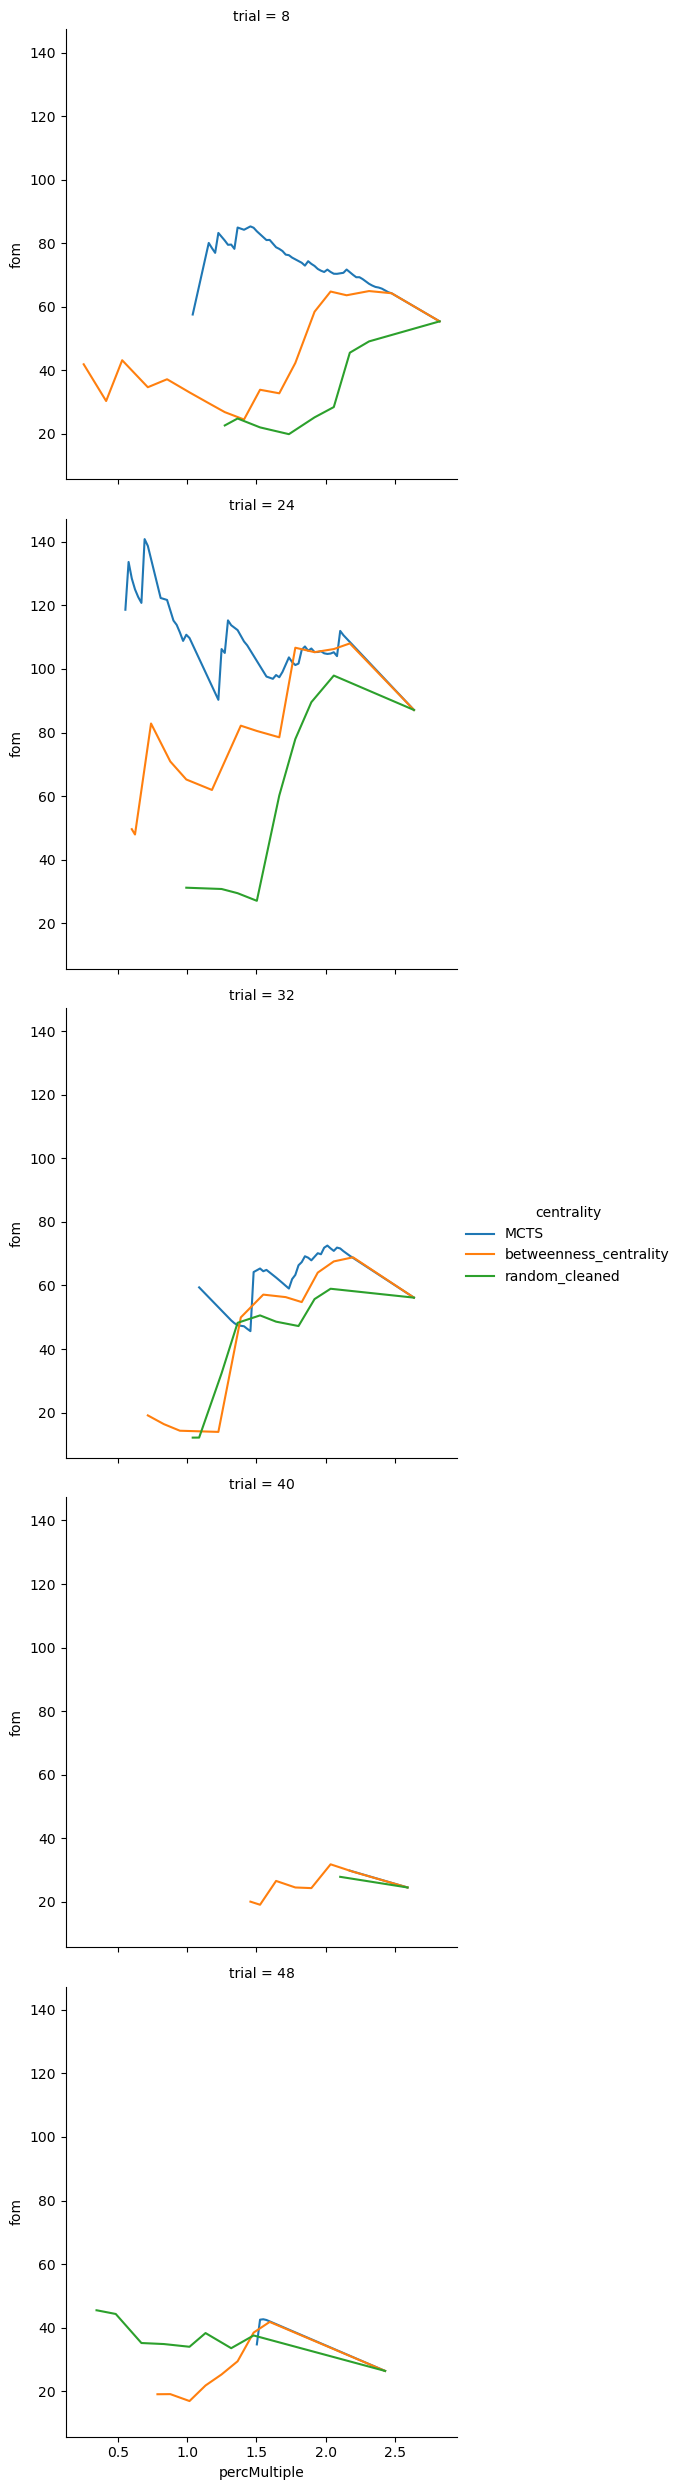

In [7]:
import seaborn as sns
snsdf = df[df.trial %8 == 0]
snsplot = sns.relplot(
    data = snsdf,
    row = 'trial',
    x = 'percMultiple',
    y = 'fom',
    hue = 'centrality',
    kind = 'line'
)
plt.show()